# Preprocessing Pipeline


The goal of the preprocessing pipeline here is to serve as a draft. Before we perform spike inference. This could be using oases or other more sophisticated method.


In [2]:
import utils as U
import importlib
import numpy as np
importlib.reload(U)

data = U.load_data()

# Time stamps for the Measured Signal. 

The timestamp for the measured signal consists of $105868$ measured time stamps over the full experimental range. The sampling 
rate we deduce from the timesamps is roughly $30.14$ Hz. 

In [3]:
print(f"Number of samples: {data['t'].shape[0]}")
# Deduced sampling rate
sampling_rate = 1 / np.mean(np.diff(data['t']))
print(f"Deduced sampling rate: {sampling_rate} Hz")

Number of samples: 105968
Deduced sampling rate: 30.144897456157484 Hz


# DFF Signal 

The DFF signal extends to the entire duration of the experiment which is $189 \times 105968$ samples of data. For each of the $189$ neurons. The main task for preprocessing this signal is to correct for any drift in the data before running spike inference on the dataset. 

In [4]:
def neuron_signal_segment(neuron_idx, start_t, end_t, sampling_rate):
    # DEFINE SEGMENT & TIME VECTOR
    sr_new = int(sampling_rate)  # Hz after downsampling
    start_idx = start_t * sr_new
    end_idx = end_t * sr_new
    time = np.linspace(start_t, end_t, end_idx - start_idx, endpoint=False)
    cell_gcamp = neuron_idx
    gcamp_cal_seg = data["dff"][cell_gcamp, start_idx:end_idx]
    return time, gcamp_cal_seg

In [5]:
from scipy.signal import butter, filtfilt, savgol_filter


def process_neuron_signal(neuron_cal_segment, sampling_rate):    
    # PARAMETERS
    fs = int(sampling_rate)  # Hz (after downsampling)
    hp_cutoff = 0.01  # Hz, to remove very slow drifts
    savgol_window = 21  # samples (~0.6 s window)
    savgol_poly = 2  # quadratic fit for Savitzky–Golay

    def preprocess_calcium(data):
        # High-pass Butterworth filter
        b, a = butter(N=4, Wn=hp_cutoff / (fs / 2), btype='highpass')
        filtered = filtfilt(b, a, data, axis=0)

        # Savitzky–Golay filter
        smoothed = savgol_filter(filtered, window_length=savgol_window, polyorder=savgol_poly, axis=0)
        return smoothed  

    gcamp_cal_filt = preprocess_calcium(neuron_cal_segment)

    return gcamp_cal_filt

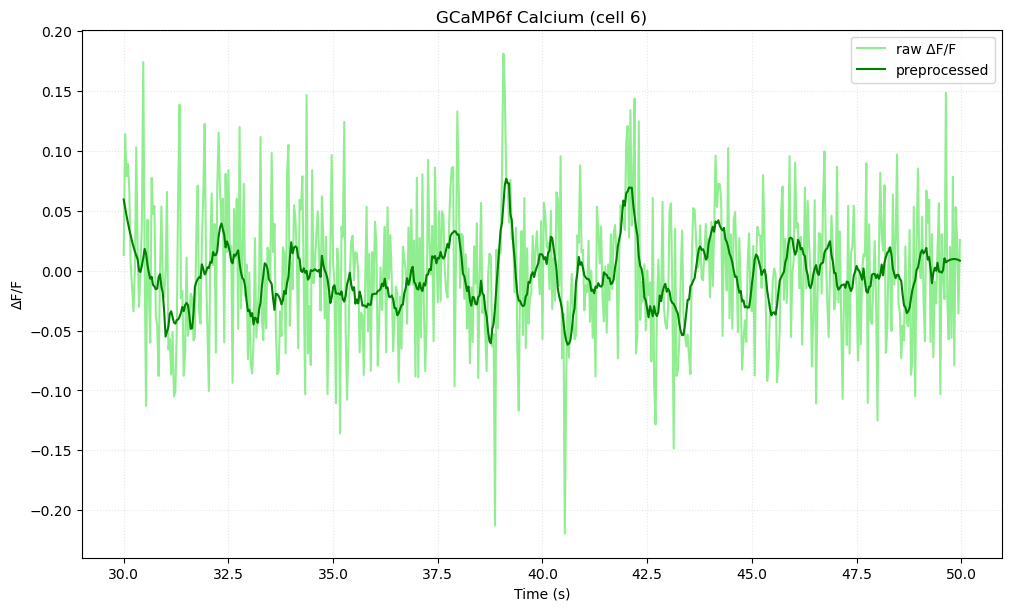

In [6]:
import matplotlib.pyplot as plt

time, gcamp_cal_seg = neuron_signal_segment(6, 30, 50, sampling_rate)
gcamp_cal_filt = process_neuron_signal(gcamp_cal_seg, sampling_rate)

fig, axs = plt.subplots( nrows=1, ncols=1, 
                        figsize=(10, 6), constrained_layout=True)

# GCaMP6f panel
axs.plot(time, gcamp_cal_seg, color="lightgreen", label="raw ΔF/F")
axs.plot(time, gcamp_cal_filt, color="green", label="preprocessed")
axs.set_title("GCaMP6f Calcium (cell 6)")
axs.set_xlabel("Time (s)")
axs.set_ylabel("ΔF/F")
axs.legend()
axs.grid(alpha=0.3, linestyle=":")


/Users/aakarsh/opt/anaconda3/envs/tue-summer-2025-oasis/lib/python3.11/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +
/Users/aakarsh/opt/anaconda3/envs/tue-summer-2025-oasis/lib/python3.11/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


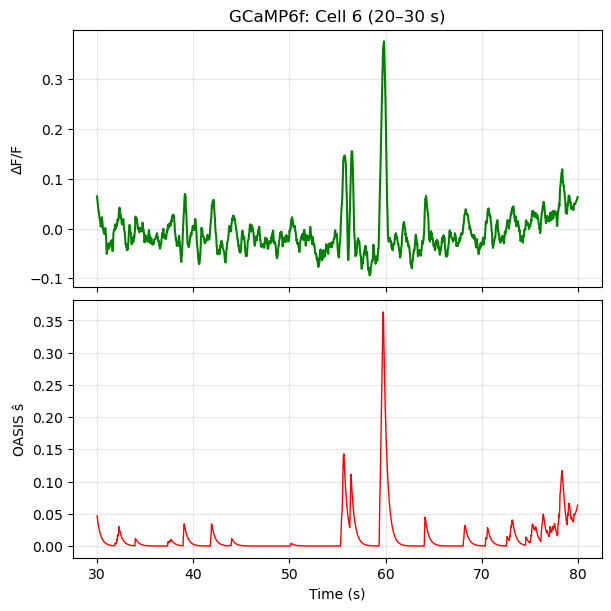

In [7]:
import oasis.functions

# Define a simple Oasis wrapper
def run_oasis(trace, penalty=1.0):
    _, s, _, _, _ = oasis.functions.deconvolve(trace, penalty=penalty, optimize_g=False)
    return s

time, gcamp_cal_seg = neuron_signal_segment(6, 30, 80, sampling_rate)
gcamp_cal_filt = process_neuron_signal(gcamp_cal_seg, sampling_rate)

# Parameters and indices
fs = sampling_rate  # Sampling rate after down-sampling (Hz)


c_oasis_gcamp_cal_seg, s_oasis_gcamp_cal_seg, *_ = oasis.functions.deconvolve(
    gcamp_cal_filt, penalty=1.0, optimize_g=False
)


# Plot GCaMP6f results (3×1)
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
axs[0].plot(time, gcamp_cal_filt, color="green")
axs[0].set_ylabel("ΔF/F")
axs[0].set_title("GCaMP6f: Cell 6 (20–30 s)")

# ← same change here
axs[1].plot(time, c_oasis_gcamp_cal_seg, color="red", linewidth=1)
axs[1].set_ylabel("OASIS ŝ")
axs[1].set_xlabel("Time (s)")

for ax in axs:
    ax.grid(alpha=0.3)
plt.show()


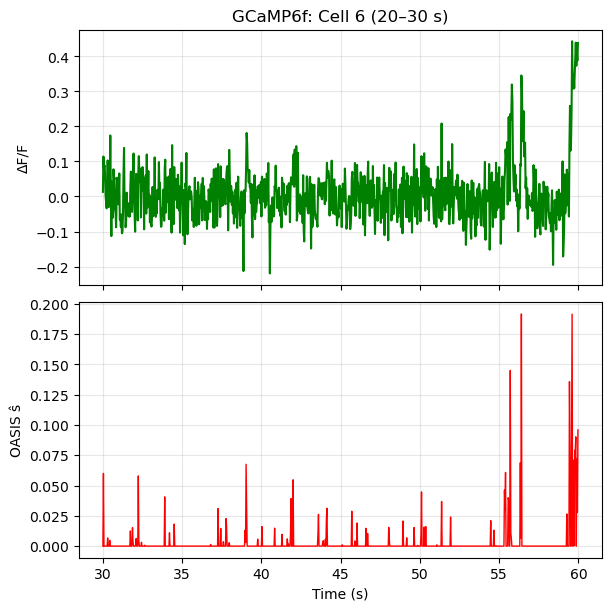

In [8]:
import oasis.functions

# Define a simple Oasis wrapper
def run_oasis(trace, penalty=1.0):
    _, s, _, _, _ = oasis.functions.deconvolve(trace, penalty=penalty, optimize_g=False)
    return s

time, gcamp_cal_seg = neuron_signal_segment(6, 30, 60, sampling_rate)

# Parameters and indices
fs = sampling_rate  # Sampling rate after down-sampling (Hz)

c_oasis_gcamp_cal_seg, s_oasis_gcamp_cal_seg, *_ = oasis.functions.deconvolve(
    gcamp_cal_seg, penalty=1.0, optimize_g=False
)

# Plot GCaMP6f results (3×1)
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
axs[0].plot(time, gcamp_cal_seg, color="green")
axs[0].set_ylabel("ΔF/F")
axs[0].set_title("GCaMP6f: Cell 6 (20–30 s)")

# ← same change here
axs[1].plot(time, s_oasis_gcamp_cal_seg, color="red", linewidth=1)
axs[1].set_ylabel("OASIS ŝ")
axs[1].set_xlabel("Time (s)")

for ax in axs:
    ax.grid(alpha=0.3)
plt.show()

In [9]:
# Run Oasis on the on raw calcium signal for all neurons
# use tqdm  to show progress
from tqdm import tqdm  
oasis_results = np.empty((data["dff"].shape[0], data['dff'].shape[1]), dtype=object) 
for neuron_idx in tqdm(range(data["dff"].shape[0]), desc="Processing neurons"):
    neuron_cal_signal = data["dff"][neuron_idx, :]
    # Run Oasis on the filtered signal
    c_oasis_gcamp_cal_seg, s_oasis_gcamp_cal_seg, *_ = oasis.functions.deconvolve(
        neuron_cal_signal, penalty=1.0, optimize_g=False
    )
    
    # Store results in data dictionary
    oasis_results[neuron_idx] = np.array(s_oasis_gcamp_cal_seg)
    
# Save the processed data


Processing neurons: 100%|██████████| 189/189 [00:14<00:00, 13.14it/s]


# Threshold the signal to infer the spike counts

The Median Absolute Deviation (MAD) provides a robust estimate of the signal's noise, 
as it's not skewed by the large values of the spikes themselves.

In [20]:
def infer_spikes_from_mad(continuous_signal: np.ndarray, std_multiplier: float = 4.0):
    """
    Infers binary spike counts from a continuous signal using a MAD-based threshold.

    Args:
        continuous_signal (np.ndarray): The 1D continuous signal from deconvolution.
        std_multiplier (float): How many standard deviations to set the threshold at.

    Returns:
        tuple[np.ndarray, float]: A tuple containing:
            - The binary spike count vector (0s and 1s).
            - The calculated threshold value.
    """
    median_val = np.median(continuous_signal)
    mad = np.median(np.abs(continuous_signal - median_val))
    noise_std = mad * 1.4826
    threshold = noise_std * std_multiplier
    
    spike_counts = (continuous_signal > threshold).astype(int)
    
    return spike_counts, threshold


spike_counts = np.zeros_like(oasis_results)
thresholds = np.zeros(oasis_results.shape[0])
for i in range(oasis_results.shape[0]):
    spike_counts[i, :], thresholds[i] = infer_spikes_from_mad(oasis_results[i, :])

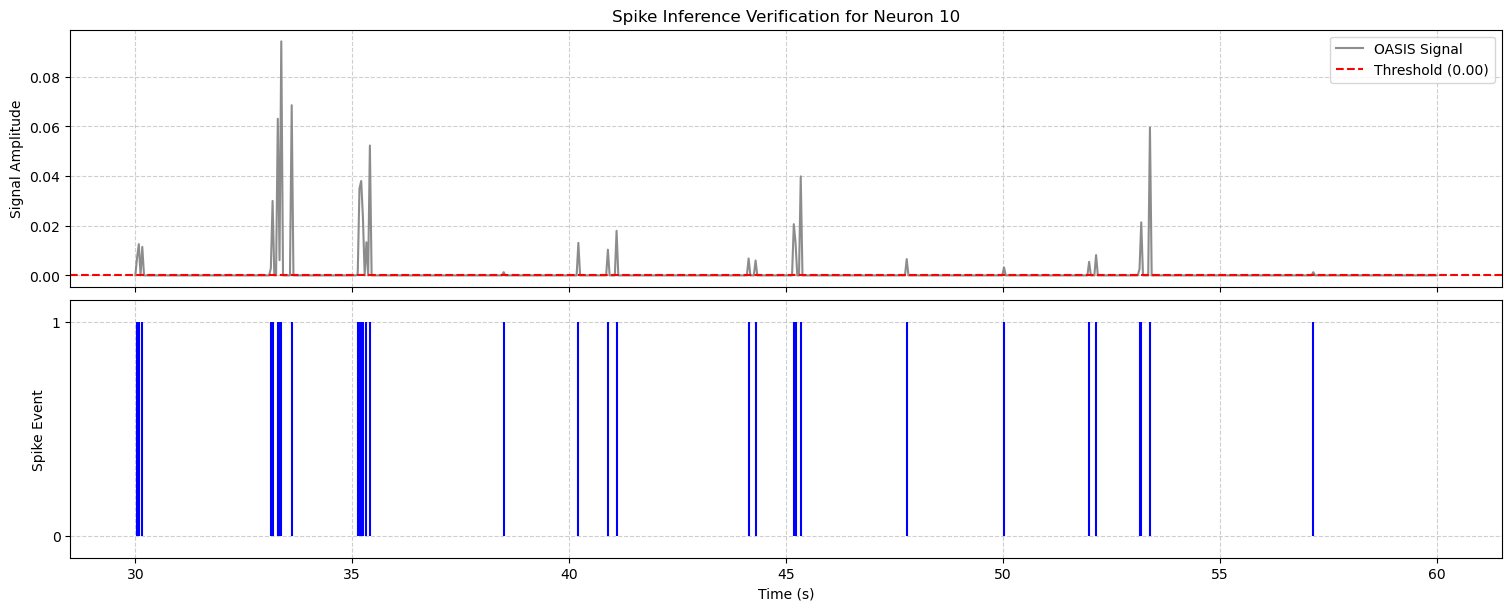

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# --- Assume you have these variables defined ---
# oasis_results:  Continuous signals, shape (neurons, timesteps)
# spike_counts:   Binary spike trains, shape (neurons, timesteps)
# thresholds:     Calculated threshold for each neuron, shape (neurons,)
sampling_rate = 25 # Hz (Example value, use your actual downsampled rate)
# ---------------------------------------------


# 1. Choose a neuron to inspect
neuron_index = 10 # Example: look at the 11th neuron

# Define time window in seconds
start_time_s = 30
end_time_s = 60

# Convert time in seconds to sample indices
start_index = int(start_time_s * sampling_rate)
end_index = int(end_time_s * sampling_rate)

# 2. Isolate the data for the chosen neuron and time window
oasis_signal_neuron = oasis_results[neuron_index, start_index:end_index]
spike_counts_neuron = spike_counts[neuron_index, start_index:end_index]
threshold_neuron = thresholds[neuron_index]

# Create a corresponding time vector for the x-axis
time_vector = np.linspace(start_time_s, end_time_s, num=len(oasis_signal_neuron))


# 3. Create the two-row plot
# sharex=True links the x-axes of both subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True, constrained_layout=True)

# --- Top Subplot: Continuous Signal ---
ax1.plot(time_vector, oasis_signal_neuron, color='gray', alpha=0.9, label='OASIS Signal')
ax1.axhline(threshold_neuron, color='red', linestyle='--', label=f'Threshold ({threshold_neuron:.2f})')
ax1.set_ylabel("Signal Amplitude")
ax1.set_title(f"Spike Inference Verification for Neuron {neuron_index}")
ax1.legend(loc='upper right')
ax1.grid(True, linestyle='--', alpha=0.6)


# --- Bottom Subplot: Inferred Spikes ---
(markers, stemlines, baseline) = ax2.stem(
    time_vector,
    spike_counts_neuron,
    linefmt='b-',
    markerfmt=' ',
    basefmt=" "
)
# Make the spike stems thinner for clarity
plt.setp(stemlines, 'linewidth', 1.5)
ax2.set_ylabel("Spike Event")
ax2.set_xlabel("Time (s)")
# Set y-axis to clearly show 0 and 1
ax2.set_ylim(-0.1, 1.1)
ax2.set_yticks([0, 1])
ax2.grid(True, linestyle='--', alpha=0.6)


# Display the plot
plt.show()

In [26]:
# Save the oasis processed data to file in preproceesing direcotry under name space "aakarsh" as a npz
# file with the current and timestamp. 
from datetime import datetime
name = "aakarsh"  # Change this to your namespace if needed
output_dir = f'./data/{name}/preprocessed/'
run_date_prefix_current_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
print(f"Saving inferred spikes data to file: {run_date_prefix_current_time}")
output_filename = f'{output_dir}/oasis_preprocessed_recordings_{run_date_prefix_current_time}.npz'

np.savez_compressed(
    output_filename,    
    processed_neuron_signal=oasis_results,
    spike_counts=spike_counts,
    thresholds=thresholds,
    sampling_frequency=sampling_rate,
    time_vector=time,
)

Saving inferred spikes data to file: 2025_07_18_10_16_01
